**TODO**

Data Cleaning:
- Make sure to convert all values in data set properly when combining, if a player is not in attacking data set for example, it is due to all of their values in that position being 0.

Logistic Regression:
- Combine more features from the different data sets into Mega UCL by hand. Then run model on it after checking for uncorrealted/stastically significant features.
- Run k-fold on mega data frame too.

K-Means:
- Normalize data
- Get Mega_UCL data set to run k-means on, similar process to logistic regression above.
- Run model (simple) with uncorrelated features and NO POSITION, whole point is to be independent of it.
- See results and analyze whether players grouped by position or natural archetype (harder)

**Set up modules/data**

In [526]:
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm

pd.options.mode.copy_on_write = True
import random
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)

In [527]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import RocCurveDisplay
roc_curve_est = RocCurveDisplay.from_estimator 
roc_curve_pred = RocCurveDisplay.from_predictions 
import statsmodels.api as sm


from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      RandomForestClassifier as RFC,
      GradientBoostingRegressor as GBR,
      GradientBoostingClassifier as GBC
)

from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from ISLP.models import sklearn_sm

from sklearn.cluster import \
     (KMeans,
      AgglomerativeClustering)
from scipy.cluster.hierarchy import \
     (dendrogram,
      cut_tree)
from ISLP.cluster import compute_linkage

from sklearn.metrics import confusion_matrix, accuracy_score



Load data set

In [528]:
UCL_key = pd.read_csv('../Data/key_stats.csv')

UCL_key

,player_name,club,position,minutes_played,match_played,goals,assists,distance_covered
0,Courtois,Real Madrid,Goalkeeper,1230,13,0,0,64.2
1,Vinícius Júnior,Real Madrid,Forward,1199,13,4,6,133.0
2,Benzema,Real Madrid,Forward,1106,12,15,1,121.5
3,Modrić,Real Madrid,Midfielder,1077,13,0,4,124.5
4,Éder Militão,Real Madrid,Defender,1076,12,0,0,110.4
...,...,...,...,...,...,...,...,...
742,Gil Dias,Benfica,Midfielder,1,1,0,0,0.7
743,Rodrigo Ribeiro,Sporting CP,Forward,1,1,0,0,0.7
744,Cojocari,Sheriff,Defender,1,1,0,0,0.5
745,Maouassa,Club Brugge,Defender,1,1,0,0,0.2


In [529]:
import pandas as pd
from functools import reduce

# --- Load all the CSVs ---
key_stats    = pd.read_csv('../Data/key_stats.csv')      # base
disciplinary = pd.read_csv('../Data/disciplinary.csv')
attacking    = pd.read_csv('../Data/attacking.csv')
attempts     = pd.read_csv('../Data/attempts.csv')
defending    = pd.read_csv('../Data/defending.csv')
distribution = pd.read_csv('../Data/distributon.csv')
goals        = pd.read_csv('../Data/goals.csv')          # skip goalkeeping.csv

# --- Helper: add a prefix to ALL non-key columns so names are unique ---
def prefix_cols(df, prefix):
    return df.rename(columns={
        col: f'{prefix}_{col}' for col in df.columns if col != 'player_name'
    })

# Give each dataframe its own column namespace
key_stats_p    = prefix_cols(key_stats,    'ks')
disciplinary_p = prefix_cols(disciplinary, 'disc')
attacking_p    = prefix_cols(attacking,    'att')
attempts_p     = prefix_cols(attempts,     'attmpt')
defending_p    = prefix_cols(defending,    'def')
distribution_p = prefix_cols(distribution, 'dist')
goals_p        = prefix_cols(goals,        'goal')

# --- Put them into a list ---
datasets = [
    key_stats_p,
    disciplinary_p,
    attacking_p,
    attempts_p,
    defending_p,
    distribution_p,
    goals_p,
]

# --- Merge everything on player_name using outer join ---
mega_UCL = reduce(
    lambda left, right: pd.merge(left, right, on='player_name', how='outer'),
    datasets
)

# Optional: fill missing values
mega_UCL = mega_UCL.fillna(0)
mega_UCL

#REDO ONLY WITH MAN MADE FEATURES THAT WE SELECT!!!!

,player_name,ks_club,ks_position,ks_minutes_played,ks_match_played,ks_goals,ks_assists,ks_distance_covered,disc_serial,disc_club,...,goal_position,goal_goals,goal_right_foot,goal_left_foot,goal_headers,goal_others,goal_inside_area,goal_outside_areas,goal_penalties,goal_match_played
0,Aaronson,Salzburg,Midfielder,715.0,8.0,0.0,2.0,103.5,326.0,Salzburg,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Abubakari,Malmö,Forward,116.0,4.0,0.0,0.0,15.3,146.0,Malmö,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Acuña,Sevilla,Defender,379.0,5.0,0.0,0.0,43.2,31.0,Sevilla,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Adams,Leipzig,Midfielder,292.0,5.0,0.0,0.0,38.9,146.0,Leipzig,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Adamu,Salzburg,Forward,231.0,8.0,1.0,0.0,32.6,55.0,Salzburg,...,Forward,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,Óscar Rodríguez,Sevilla,Midfielder,22.0,1.0,0.0,0.0,3.8,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999,Čolak,Malmö,Forward,500.0,6.0,0.0,0.0,63,40.0,Malmö,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,Šeško,Salzburg,Forward,234.0,6.0,0.0,0.0,32.1,263.0,Salzburg,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,Šimić,Salzburg,Forward,4.0,1.0,0.0,0.0,1.3,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [530]:
def predict(X, model):
    # the built-in get_prediction tool returns an array, so we need to convert to a dataframe
    predictions_df = pd.DataFrame(model.get_prediction(X).predicted, columns=['y_hat'], index=X.index)
    return predictions_df['y_hat']

In [531]:
megaUCL = mega_UCL.drop_duplicates(subset=['player_name', 'ks_club']) #gets rid of dupelicate rows by looking at name and club

megaUCL


,player_name,ks_club,ks_position,ks_minutes_played,ks_match_played,ks_goals,ks_assists,ks_distance_covered,disc_serial,disc_club,...,goal_position,goal_goals,goal_right_foot,goal_left_foot,goal_headers,goal_others,goal_inside_area,goal_outside_areas,goal_penalties,goal_match_played
0,Aaronson,Salzburg,Midfielder,715.0,8.0,0.0,2.0,103.5,326.0,Salzburg,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Abubakari,Malmö,Forward,116.0,4.0,0.0,0.0,15.3,146.0,Malmö,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Acuña,Sevilla,Defender,379.0,5.0,0.0,0.0,43.2,31.0,Sevilla,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Adams,Leipzig,Midfielder,292.0,5.0,0.0,0.0,38.9,146.0,Leipzig,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Adamu,Salzburg,Forward,231.0,8.0,1.0,0.0,32.6,55.0,Salzburg,...,Forward,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,Óscar Rodríguez,Sevilla,Midfielder,22.0,1.0,0.0,0.0,3.8,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999,Čolak,Malmö,Forward,500.0,6.0,0.0,0.0,63,40.0,Malmö,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,Šeško,Salzburg,Forward,234.0,6.0,0.0,0.0,32.1,263.0,Salzburg,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,Šimić,Salzburg,Forward,4.0,1.0,0.0,0.0,1.3,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [532]:
megaUCL[megaUCL['player_name'].duplicated()]['player_name'].unique() #shows players with same last name

array(['Camara', 'Correa', 'Danilo', 'Diallo', 'Fernando', 'Henderson',
       'Herrera', 'João Mário', 'Karavaev', 'Martínez', 'Mendy', 'Onana',
       'Peña', 'Sarr', 'Steffen'], dtype=object)

In [533]:
Dupes = mega_UCL[mega_UCL['player_name'].duplicated()]['player_name'].unique()  #shows rows of players with same last name

#for name in Dupes:
    #print("\n=== Rows for:", name, "===")
    #display(megaUCL[megaUCL['player_name'] == name])

**Logistic Regression:**

Find correlated features

In [534]:
print(mega_UCL.columns)

Index(['player_name', 'ks_club', 'ks_position', 'ks_minutes_played',
       'ks_match_played', 'ks_goals', 'ks_assists', 'ks_distance_covered',
       'disc_serial', 'disc_club', 'disc_position', 'disc_fouls_committed',
       'disc_fouls_suffered', 'disc_red', 'disc_yellow', 'disc_minutes_played',
       'disc_match_played', 'att_serial', 'att_club', 'att_position',
       'att_assists', 'att_corner_taken', 'att_offsides', 'att_dribbles',
       'att_match_played', 'attmpt_serial', 'attmpt_club', 'attmpt_position',
       'attmpt_total_attempts', 'attmpt_on_target', 'attmpt_off_target',
       'attmpt_blocked', 'attmpt_match_played', 'def_serial', 'def_club',
       'def_position', 'def_balls_recoverd', 'def_tackles', 'def_t_won',
       'def_t_lost', 'def_clearance_attempted', 'def_match_played',
       'dist_serial', 'dist_club', 'dist_position', 'dist_pass_accuracy',
       'dist_pass_attempted', 'dist_pass_completed', 'dist_cross_accuracy',
       'dist_cross_attempted', 'dist_cro

Find stastically significant features in data set

In [535]:
print(UCL_key.columns)
print(UCL_key['position'].unique().tolist())

Index(['player_name', 'club', 'position', 'minutes_played', 'match_played',
       'goals', 'assists', 'distance_covered'],
      dtype='object')
['Goalkeeper', 'Forward', 'Midfielder', 'Defender']


In [536]:
UCL_key['position'] = UCL_key['position'].map({'Defender': 0, 'Forward': 1, 'Goalkeeper': 0, 'Midfielder': 1})

X_UCL_key = UCL_key.drop(columns=['player_name', 'position', 'club'])
X_UCL_key = X_UCL_key.apply(pd.to_numeric, errors='coerce').fillna(0)
Y_UCL_key = UCL_key['position'].astype(int)

In [537]:
glm = sm.GLM(Y_UCL_key,
             X_UCL_key,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

#Assists not significant

,coef,std err,z,P>|z|
minutes_played,-0.0374,0.004,-9.489,0.000
match_played,0.2491,0.068,3.682,0.000
goals,1.4002,0.209,6.690,0.000
assists,0.1614,0.142,1.136,0.256
distance_covered,0.2792,0.034,8.133,0.000


In [538]:
X_UCL_key = UCL_key[['minutes_played', 'match_played', 'goals', 'distance_covered']] #remove assists
X_UCL_key = X_UCL_key.apply(pd.to_numeric, errors='coerce').fillna(0)
Y_UCL_key = UCL_key['position'].astype(int)

glm2 = sm.GLM(Y_UCL_key,
             X_UCL_key,
             family=sm.families.Binomial())
results = glm2.fit()
summarize(results)

,coef,std err,z,P>|z|
minutes_played,-0.0375,0.004,-9.524,0.0
match_played,0.2481,0.067,3.678,0.0
goals,1.4335,0.207,6.932,0.0
distance_covered,0.2817,0.034,8.211,0.0


In [539]:
probs_UCL=predict(X_UCL_key,results)

In [540]:
predictions_train = np.array([True]*len(Y_UCL_key))
predictions_train[probs_UCL<0.6] = False

In [541]:
confusion_table(predictions_train, Y_UCL_key)

Truth,0,1
Predicted,,
0,223,111
1,81,332


In [542]:
#Now try with other variables from mega UCL

Run k-fold to test data since less than 1000 observations

In [543]:
#make folds
kf = KFold(n_splits=5, shuffle=True, random_state=70)

folds = []
for train_idx, test_idx in kf.split(X_UCL_key):
    folds.append({"train_idx": train_idx, "test_idx": test_idx})

# Optional: peek at counts per fold
for i, f in enumerate(folds, start=1):
    print(f"Fold {i}: train={len(f['train_idx'])}, test={len(f['test_idx'])}")

Fold 1: train=597, test=150
Fold 2: train=597, test=150
Fold 3: train=598, test=149
Fold 4: train=598, test=149
Fold 5: train=598, test=149


In [544]:
train_idx, test_idx = next(iter(kf.split(X_UCL_key)))

X_UCL_key = UCL_key[['minutes_played', 'match_played', 'goals', 'distance_covered']] #remove assists
X_UCL_key = X_UCL_key.apply(pd.to_numeric, errors='coerce').fillna(0)
Y_UCL_key = UCL_key['position'].astype(int)

X_train = X_UCL_key.iloc[train_idx].copy()
y_train = Y_UCL_key.iloc[train_idx].copy()
X_test  = X_UCL_key.iloc[test_idx].copy()
y_test  = Y_UCL_key.iloc[test_idx].copy()

glmfold1 = sm.GLM(y_train, X_train, family=sm.families.Binomial())
glmfold1_results = glmfold1.fit()

probs_fold1=predict(X_test,glmfold1_results)
y_pred = (probs_fold1 >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Fold 1):\n", cm)

Confusion Matrix (Fold 1):
 [[26 23]
 [18 83]]


In [545]:
total_missclassifaction  = []
false_positive_rate = []
false_negative_rate = []

total_missclassifaction.append((cm[0,1]+cm[1,0])/np.sum(cm))
false_positive_rate.append(cm[0,1]/(cm[0,1]+cm[0,0]))
false_negative_rate.append(cm[1,0]/(cm[1,0]+cm[ 1,1]))

print(total_missclassifaction, false_positive_rate, false_negative_rate)

[np.float64(0.2733333333333333)] [np.float64(0.46938775510204084)] [np.float64(0.1782178217821782)]


In [546]:
#Repeat this, if results still bad, lets try adding the other features. If bad ok, can say that these 
#features are not predictiven and can compare to k-means to see difference.
#This can show, players grouped by player archetype rather than position and can apply.

**K-means Clustering**

In [ ]:
UCL_k_means = pd.read_csv('../Data/key_stats.csv')


UCL_k_means_numeric = UCL_k_means.select_dtypes(include=[np.number]).fillna(0)

Normalize data

In [548]:
#do this on UCL-Mega too, just test run for key_stats

scaler = StandardScaler()
UCL_key_normalized = scaler.fit_transform(UCL_k_means_numeric)

Run k-means, we can discuss what best one is or switch to hierarchial

In [ ]:
#I was thinking 4 for 4 positions or we can research how many football archetypes there are
#Test different k to see until good split

kmeans = KMeans(n_clusters=3,
                random_state=1,
                n_init=1).fit(UCL_key_normalized)

cluster_km = pd.DataFrame(kmeans.labels_)
cluster_km.index=UCL_key.index
cluster_km

,0
0,0
1,2
2,2
3,2
4,0
...,...
742,1
743,1
744,1
745,1


In [554]:
UCL_key['cluster_km']=cluster_km
UCL_key.sort_values('cluster_km')
cluster_0 = UCL_key[UCL_key['cluster_km'] == 0]
cluster_1 = UCL_key[UCL_key['cluster_km'] == 1]
cluster_2 = UCL_key[UCL_key['cluster_km'] == 2]

In [ ]:
#Make it so prints player, team, position

print(f'The players in cluster 0 are '
      f'{cluster_0.index.unique().tolist()}. '
      f'The players in cluster 1 are '
      f'{cluster_1.index.unique().tolist()}. ' 
      f'The players in cluster 2 are '
      f'{cluster_2.index.unique().tolist()}')

#then run analysis

The states in cluster 0 are [0, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 25, 27, 28, 30, 32, 34, 35, 36, 38, 39, 41, 42, 44, 45, 53, 54, 57, 58, 61, 62, 63, 64, 68, 70, 71, 72, 73, 74, 75, 77, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 117, 118, 119, 120, 121, 123, 125, 128, 129, 130, 131, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 153, 154, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 198, 199, 200, 201, 202, 203, 204, 206, 207, 208, 210, 211, 212, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 265, 266, 267, 268, 269, 270, 271, 272, 273,

KeyError: 'Distance_covered'

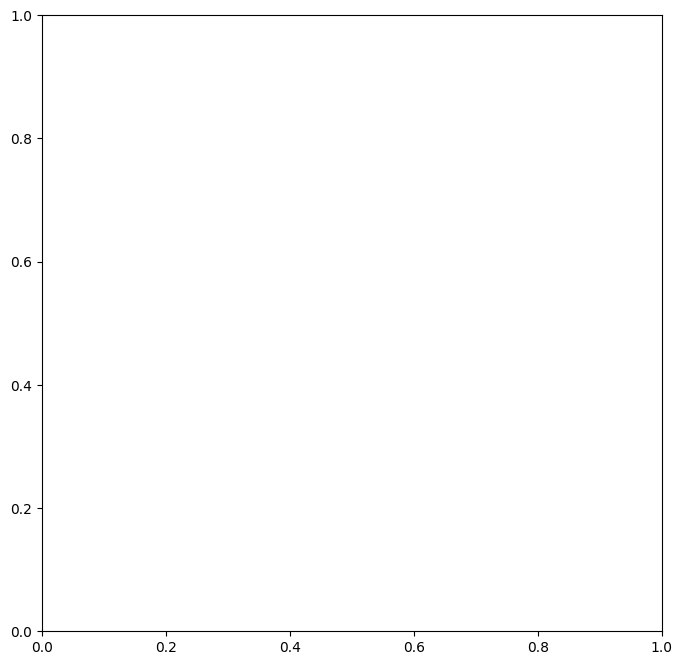

In [558]:
#TODO

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(UCL_key['Distance_covered'], UCL_key['Dribbles'], c=UCL_key['cluster_km'])
ax.set_title("K-Means Clustering Results with K=3")
ax.set_xlabel('Voting Local')
ax.set_ylabel('Organizaion Membership');

**Random Forest**

Run the random forest

In [550]:
#See if random forest gives better results (misclassification rate)

Compare to logistic regression